## Analyzing New York Red Bulls 2024 Performance in MLS Games

## Context
The New York Red Bulls, aka RBNY, are one of the teams in Major League Soccer (MLS). They are one of the ten charter clubs of MLS, having competed in the league since its founding in 1996.

 vs NYCFC game?

1. Performance of team across years: dot plot of goals/games across years. the question, are they improving overall as a team.
2. Gather info across the years to see what characteristics for attackers, defenders, midfielders allows for higher goal scoring. 3 Heat maps. 
3. on an individual basis, how can these characteristics help the players improve. do they have values that are outliers which they should focus on.
4. tableau dashboard.


In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

Load all data

In [128]:
all_data = {}

for year in range(2010, 2025):
    file_path = f"RBNY_yearly_stats/main_stats/all_{year}_stats.xlsx"
    sheets = pd.ExcelFile(file_path).sheet_names  # Get all sheet names
    
    # Load sheets with different skiprows based on sheet name
    dataframes = {
        f"{sheet}_{year}": pd.read_excel(file_path, sheet_name=sheet, skiprows=1 if sheet.lower() == "score" else 2)
        for sheet in sheets
    }
    
    all_data.update(dataframes)  # Store in the main dictionary    

## Team performance across years


Question: Is the performance of RBNY team improving over the years?



Analysis: The points per game (PPG) have been calculated from 2010 to 2024 which is a measure to assess the teams performance. 

$$
\displaystyle
ppg = \frac{3 \cdot \sum win + \sum draw}{\sum game}
$$

Finding: No overall improvement has been noted. However, the two extreme points were 2018 with high result (2.10 ppg) and 2023 with bad result (1.24 ppg). Lets evaluate what factors might have contributed to such different results.

Calculating team performance across years

In [59]:
# Function to calculate PPG for a given DataFrame
def ppg_calculation(ppg_data, df, year):
    wins = (df["Result"] == "W").sum()
    draws = (df["Result"] == "D").sum()
    games = len(df)

    if games > 0:
        ppg_data[year] = (3 * wins + draws) / games
    else:
        ppg_data[year] = None  # If no games, set PPG as None

In [60]:
# Dictionary to store PPG values
ppg_data = {}

# Iterate over the years to calculate PPG
for year in range(2010, 2025):
    sheet_name = f"score_{year}"  # The sheet name with the year appended

    if sheet_name in all_data:  # Ensure the sheet exists
        df = all_data[sheet_name]

        if "Result" in df.columns:
            df.columns = df.columns.str.strip()  # Remove any leading/trailing spaces
            ppg_calculation(ppg_data, df, year)  # Pass the correct arguments
        else:
            ppg_data[year] = None  # If "Result" column is missing, set PPG as None



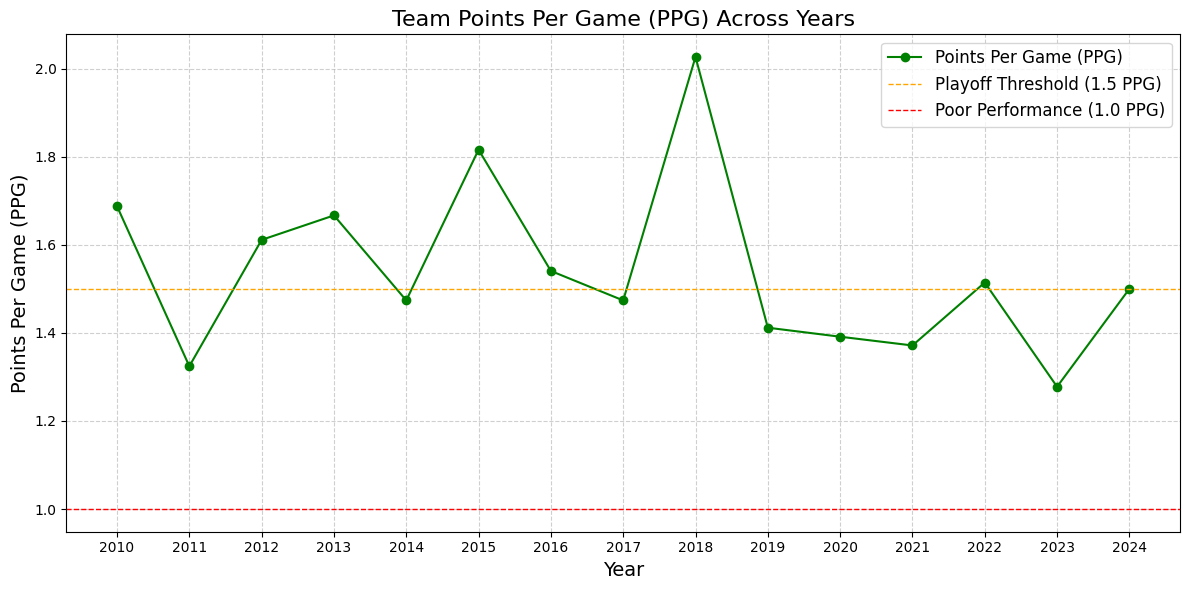

In [61]:
# Convert to DataFrame for plotting
ppg_df = pd.DataFrame(list(ppg_data.items()), columns=["Year", "PPG"])

# Plot PPG over the years
plt.figure(figsize=(12, 6))
plt.plot(ppg_df["Year"], ppg_df["PPG"], marker='o', linestyle='-', color='green', label="Points Per Game (PPG)")
plt.axhline(1.5, color='orange', linestyle='--', linewidth=1, label="Playoff Threshold (1.5 PPG)")
plt.axhline(1.0, color='red', linestyle='--', linewidth=1, label="Poor Performance (1.0 PPG)")
plt.title("Team Points Per Game (PPG) Across Years", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Points Per Game (PPG)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(ppg_df["Year"])
plt.tight_layout()
plt.show()


## Understanding the Performance Gap from 2018 to 2024

Analysis: 
- Determine whether there is a significant difference in team metrics between 2018 and 2024. The analysis will categorize metrics based on player positions—attacker, midfielder, defender, and goalkeeper—since each role has specific performance indicators.
- Calculate the average and standard deviation for all metrics from both the 2018 and 2024 data sets. This data will be segmented by player roles to provide a visual representation, ensuring that any significant differences observed are meaningful and intuitive.

In [62]:
# display all columns
pd.set_option('display.max_columns', None)


Set all sheets from 2018 and 2024 RBNY Stats into dataframe

In [129]:
# Print loaded DataFrame names for reference
print("Loaded DataFrames:")
for df_name in all_data.keys():
    print(df_name)

# Example: Access a specific DataFrame
# For example, general_stats_2018 or general_stats_2024
general_stats_2018 = all_data.get("standard_stats_2018")
general_stats_2024 = all_data.get("standard_stats_2024")


Loaded DataFrames:
standard_stats_2010
score_2010
goalkeeping_2010
shooting_2010
miscellaneous_2010
standard_stats_2011
score_2011
goalkeeping_2011
shooting_2011
miscellaneous_2011
standard_stats_2012
score_2012
goalkeeping_2012
shooting_2012
miscellaneous_2012
standard_stats_2013
score_2013
goalkeeping_2013
shooting_2013
miscellaneous_2013
standard_stats_2014
score_2014
goalkeeping_2014
shooting_2014
miscellaneous_2014
standard_stats_2015
score_2015
goalkeeping_2015
shooting_2015
miscellaneous_2015
standard_stats_2016
score_2016
goalkeeping_2016
scoring_2016
miscenalleous_2016
standard_stats_2017
score_2017
goalkeeping_2017
shooting_2017
miscenallenous_2017
standard_stats_2018
score_2018
goalkeeping_2018
advanced_goalkeeping_2018
shooting_2018
passing_2018
defensive_action_2018
possession_2018
standard_stats_2019
score_2019
goalkeeping_2019
advanced_goalkeeping_2019
shooting_2019
passing_2019
defensive_action_2019
possession_2019
standard_stats_2020
score_2020
goalkeeping_2020
advance

In [130]:
# Identify the general stats columns (from the first sheet)
general_stats_2018_cols = set(all_data.get("standard_stats_2018", pd.DataFrame()).columns)
general_stats_2024_cols = set(all_data.get("standard_stats_2024", pd.DataFrame()).columns)

# Drop Pos because it must be kept in all sheets
general_stats_2018_cols = [col for col in general_stats_2024_cols if col not in {"Pos", "Player"}]
general_stats_2024_cols = [col for col in general_stats_2024_cols if col not in {"Pos", "Player"}]

print(general_stats_2018_cols)


['Ast', 'xAG', '90s', 'Nation', 'CrdR', 'Gls.1', 'xG.1', 'G-PK', 'PK', 'PKatt', 'Age', 'PrgR', 'MP', 'npxG+xAG', 'G+A-PK', 'PrgP', 'Matches', 'Min', 'G+A', 'npxG+xAG.1', 'Ast.1', 'npxG.1', 'G+A.1', 'xG+xAG', 'G-PK.1', 'CrdY', 'xAG.1', 'Gls', 'Starts', 'npxG', 'xG', 'PrgC']


Remove repeating columns in different sheets

In [131]:
# Create a new dictionary for non-repeating columns
filtered_data = {}

for df_name, df in all_data.items():
    # Only keep data from 2018 and 2024
    if "2018" not in df_name and "2024" not in df_name:
        continue  # Skip any other years

    # Always keep the general stats sheets for these years
    if df_name in ["standard_stats_2018", "standard_stats_2024"]:
        filtered_data[df_name] = df
        continue

    # Identify non-repeating columns based on the respective general stats columns
    reference_cols = general_stats_2018_cols if "2018" in df_name else general_stats_2024_cols
    non_repeating_cols = [col for col in df.columns if col not in reference_cols]

    # Store only the unique columns in the new DataFrame
    filtered_data[df_name] = df[non_repeating_cols]

# Print filtered DataFrame names
print("Filtered DataFrames (2018 & 2024, without repeating columns):")
for df_name, df in filtered_data.items():
    print(df_name, df.shape)


Filtered DataFrames (2018 & 2024, without repeating columns):
standard_stats_2018 (31, 34)
score_2018 (38, 19)
goalkeeping_2018 (2, 16)
advanced_goalkeeping_2018 (2, 27)
shooting_2018 (29, 14)
passing_2018 (29, 22)
defensive_action_2018 (29, 18)
possession_2018 (29, 22)
standard_stats_2024 (33, 34)
score_2024 (38, 19)
goalkeeping_2024 (2, 16)
advanced_goalkeeping_2024 (2, 27)
shooting_2024 (27, 14)
passing_2024 (27, 22)
defensive_action_2024 (27, 18)
possession_2024 (27, 22)


In [132]:
for df_name, df in filtered_data.items():
    print(f"Columns in {df_name}:")
    print(df.columns)
    print("-" * 50)

Columns in standard_stats_2018:
Index(['Player', 'Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls',
       'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG',
       'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls.1', 'Ast.1', 'G+A.1',
       'G-PK.1', 'G+A-PK', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1', 'npxG+xAG.1',
       'Matches'],
      dtype='object')
--------------------------------------------------
Columns in score_2018:
Index(['Date', 'Time', 'Comp', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA',
       'Opponent', 'xGA', 'Poss', 'Attendance', 'Captain', 'Formation',
       'Opp Formation', 'Referee', 'Match Report', 'Notes'],
      dtype='object')
--------------------------------------------------
Columns in goalkeeping_2018:
Index(['Player', 'Pos', 'GA', 'GA90', 'SoTA', 'Saves', 'Save%', 'W', 'D', 'L',
       'CS', 'CS%', 'PKA', 'PKsv', 'PKm', 'Save%.1'],
      dtype='object')
--------------------------------------------------
Columns in advanced_goalkee

Determine which metrics are significantly different from 2018 and 2024 data for all 4 player roles.

Analysis:
- Goalkeeper: for the goalkeepers it would have been ideal to calculate for a signficant difference between 2018 and 2024 for the metrics in "goalkeeping", "advanced_goalkeeping" and "standard_stats" sheets. However, statistical tests are only meaningful with a MINIMUM of 3-5 samples, whereas we only have 2 players for each year (2 samples).


Helper functions performing statistical analysis

In [142]:
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu

# Check normality (combines constant check & Shapiro)
def check_normality(data):
    if len(data) < 3:  # Too small to test normality
        return None
    if data.nunique() == 1:  # Constant data is trivially normal
        return True  
    return shapiro(data)[1] >= 0.05  # Shapiro test: True if normal, False otherwise

# Check variance with Levene’s test
def check_variance(data1, data2):
    return levene(data1, data2)[1] < 0.05  # True if variance is significantly different

# Select statistical test based on normality & variance
def select_statistical_test(values_2018, values_2024):
    normality_2018 = check_normality(values_2018)
    normality_2024 = check_normality(values_2024)

    normality_violated = (normality_2018 is not None and not normality_2018) or \
                        (normality_2024 is not None and not normality_2024)

    variance_violated = check_variance(values_2018, values_2024)

    if not normality_violated and not variance_violated:
        return ttest_ind(values_2018, values_2024, equal_var=True, nan_policy="omit"), "T-Test (Equal Var)"
    elif not normality_violated and variance_violated:
        return ttest_ind(values_2018, values_2024, equal_var=False, nan_policy="omit"), "Welch’s T-Test"
    else:
        return mannwhitneyu(values_2018, values_2024, alternative="two-sided"), "Mann-Whitney U Test"


In [149]:
# Mapping of player positions to roles
role_mappings = {
    "Attacker": ["FW", "AM", "LW", "RW"],
    "Midfielder": ["MF", "DM", "CM", "LM", "RM", "WM"],
    "Defender": ["DF", "FB", "LB", "RB", "CB"],
}

# Define relevant sheets for each position
role_sheets = {
    "Attacker": ["standard_stats", "shooting", "possession", "passing"],
    "Defender": ["standard_stats", "defensive_action", "possession"],
    "Midfielder": ["standard_stats", "passing", "possession", "defensive_action"]
}


In [148]:
# Dictionary to store results
role_comparison_results = {}
assumption_violations = {}

# Loop through each role
for role, sheets in role_sheets.items():
    positions = role_mappings[role]
    role_data = []

    # Extract relevant sheets for the role
    for df_name, df in filtered_data.items():
        sheet_base_name = "_".join(df_name.split("_")[:-1])
        if sheet_base_name not in sheets or "Pos" not in df.columns:
            continue  

        # Filter only players that match the role's positions
        df_filtered = df[df["Pos"].apply(lambda x: any(pos in str(x).split(",") for pos in positions))].copy()
        df_filtered.loc[:, "Year"] = 2018 if "2018" in df_name else 2024
        role_data.append(df_filtered)

    # Combine all role-specific data
    if not role_data:
        print(f"⚠️ No data found for {role}, skipping.")
        continue

    role_df = pd.concat(role_data, ignore_index=True)

    # Separate data by year
    role_2018 = role_df[role_df["Year"] == 2018]
    role_2024 = role_df[role_df["Year"] == 2024]

    # Identify numeric columns for statistical testing (EXCLUDE "Year")
    numeric_cols = [col for col in role_df.select_dtypes(include=["number"]).columns if col != "Year"]

    # Perform statistical testing
    p_values = []
    metrics_to_keep = []
    avg_diff = []
    test_used = []

    for metric in numeric_cols:
        values_2018 = role_2018[metric].dropna()
        values_2024 = role_2024[metric].dropna()

        if len(values_2018) < 3 or len(values_2024) < 3:
            print(f"⚠️ Skipping {metric} (Not enough data: {len(values_2018)} vs {len(values_2024)})")
            continue  

        # Select and apply the correct statistical test
        (statistic, p_val), test_name = select_statistical_test(values_2018, values_2024)

        # Store results
        test_used.append(test_name)
        p_values.append(p_val)
        avg_diff.append(values_2018.mean() - values_2024.mean())
        metrics_to_keep.append(metric)

        # Log assumption violations
        normality_violated = not check_normality(values_2018) or not check_normality(values_2024)
        variance_violated = check_variance(values_2018, values_2024)
        if normality_violated or variance_violated:
            assumption_violations[metric] = {"normality": normality_violated, "variance": variance_violated}

    # Store results in DataFrame
    comparison_df = pd.DataFrame({
        "Metric": metrics_to_keep, 
        "Avg_Diff": avg_diff, 
        "p-value": p_values, 
        "Test Used": test_used
    })
    comparison_df["Significant"] = comparison_df["p-value"] < 0.05

    # Filter only significant results
    significant_diffs = comparison_df[comparison_df["Significant"]]

    # Store results for this role
    role_comparison_results[role] = significant_diffs

    # Save to CSV
    significant_diffs.to_csv(f"RBNY_yearly_stats/significance/{role.lower()}_significant_diff.csv", index=False)

    print(f"✅ {role}: {len(significant_diffs)} significant differences found. Results saved.")

# Print summary of findings
for role, df in role_comparison_results.items():
    print(f"\n🔎 Significant differences for {role}:")
    print(df if not df.empty else "No significant differences found.")

# Print assumption violations if any
if assumption_violations:
    print("\n⚠️ Assumption violations detected for the following metrics:")
    for metric, issues in assumption_violations.items():
        print(f" - {metric}: Normality violated? {issues['normality']}, Variance violated? {issues['variance']}")


✅ Attacker: 1 significant differences found. Results saved.
✅ Defender: 1 significant differences found. Results saved.
✅ Midfielder: 2 significant differences found. Results saved.

🔎 Significant differences for Attacker:
    Metric   Avg_Diff   p-value            Test Used  Significant
52  Cmp%.2 -10.035897  0.035162  Mann-Whitney U Test         True

🔎 Significant differences for Defender:
     Metric     Avg_Diff   p-value           Test Used  Significant
55  TotDist -1586.989899  0.036868  T-Test (Equal Var)         True

🔎 Significant differences for Midfielder:
    Metric   Avg_Diff   p-value            Test Used  Significant
32    Cmp% -11.100000  0.004052   T-Test (Equal Var)         True
40  Cmp%.2  -4.388571  0.032467  Mann-Whitney U Test         True

⚠️ Assumption violations detected for the following metrics:
 - MP: Normality violated? True, Variance violated? False
 - Starts: Normality violated? True, Variance violated? False
 - Min: Normality violated? True, Variance vi

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_morestats.py:3361: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


In [146]:
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
import pandas as pd

# Dictionary to store results
year_comparison_results = {}
assumption_violations = {}

all_data = []  # List to store data from all sheets

# Loop through each sheet in filtered_data
for df_name, df in filtered_data.items():
    # Extract year from the sheet name
    year = 2018 if "2018" in df_name else 2024
    
    # Ensure the "Year" column is properly assigned
    df = df.copy()
    df.loc[:, "Year"] = year  

    # Append to the list for later merging
    all_data.append(df)

# Combine all data into a single DataFrame
if not all_data:
    print("⚠️ No data found across sheets.")
    exit()

merged_df = pd.concat(all_data, ignore_index=True)

# Separate data by year
df_2018 = merged_df[merged_df["Year"] == 2018]
df_2024 = merged_df[merged_df["Year"] == 2024]

# Identify numeric columns for statistical testing (EXCLUDE "Year")
numeric_cols = [col for col in merged_df.select_dtypes(include=["number"]).columns if col != "Year"]

# Perform statistical testing
p_values = []
metrics_to_keep = []
avg_diff = []
test_used = []

for metric in numeric_cols:
    values_2018 = df_2018[metric].dropna()
    values_2024 = df_2024[metric].dropna()

    if len(values_2018) < 3 or len(values_2024) < 3:
        print(f"⚠️ Skipping {metric} (Not enough data: {len(values_2018)} vs {len(values_2024)})")
        continue  

    # Select and apply the correct statistical test
    (statistic, p_val), test_name = select_statistical_test(values_2018, values_2024)

    # Store results
    test_used.append(test_name)
    p_values.append(p_val)
    avg_diff.append(values_2018.mean() - values_2024.mean())
    metrics_to_keep.append(metric)

    # Log assumption violations
    normality_violated = (check_normality(values_2018) is not None and not check_normality(values_2018)) or \
                         (check_normality(values_2024) is not None and not check_normality(values_2024))
    variance_violated = check_variance(values_2018, values_2024)
    if normality_violated or variance_violated:
        assumption_violations[metric] = {"normality": normality_violated, "variance": variance_violated}

# Store results in DataFrame
comparison_df = pd.DataFrame({
    "Metric": metrics_to_keep, 
    "Avg_Diff": avg_diff, 
    "p-value": p_values, 
    "Test Used": test_used
})
comparison_df["Significant"] = comparison_df["p-value"] < 0.05

# Filter only significant results
significant_diffs = comparison_df[comparison_df["Significant"]]

# Save results
significant_diffs.to_csv("RBNY_yearly_stats/significance/yearly_significant_diff.csv", index=False)

print(f"\n✅ Yearly Comparison: {len(significant_diffs)} significant differences found. Results saved.")

# Print summary of findings
print("\n🔎 Significant differences between 2018 and 2024:")
print(significant_diffs if not significant_diffs.empty else "No significant differences found.")

# Print assumption violations if any
if assumption_violations:
    print("\n⚠️ Assumption violations detected for the following metrics:")
    for metric, issues in assumption_violations.items():
        print(f" - {metric}: Normality violated? {issues['normality']}, Variance violated? {issues['variance']}")


⚠️ Skipping GA90 (Not enough data: 2 vs 2)
⚠️ Skipping SoTA (Not enough data: 2 vs 2)
⚠️ Skipping Saves (Not enough data: 2 vs 2)
⚠️ Skipping Save% (Not enough data: 2 vs 2)
⚠️ Skipping W (Not enough data: 2 vs 2)
⚠️ Skipping D (Not enough data: 2 vs 2)
⚠️ Skipping L (Not enough data: 2 vs 2)
⚠️ Skipping CS (Not enough data: 2 vs 2)
⚠️ Skipping CS% (Not enough data: 2 vs 2)
⚠️ Skipping PKsv (Not enough data: 2 vs 2)
⚠️ Skipping PKm (Not enough data: 2 vs 2)
⚠️ Skipping Save%.1 (Not enough data: 1 vs 1)
⚠️ Skipping CK (Not enough data: 2 vs 2)
⚠️ Skipping OG (Not enough data: 2 vs 2)
⚠️ Skipping PSxG (Not enough data: 2 vs 2)
⚠️ Skipping PSxG/SoT (Not enough data: 2 vs 2)
⚠️ Skipping PSxG+/- (Not enough data: 2 vs 2)
⚠️ Skipping /90 (Not enough data: 2 vs 2)
⚠️ Skipping Att (GK) (Not enough data: 2 vs 2)
⚠️ Skipping Thr (Not enough data: 2 vs 2)
⚠️ Skipping Launch% (Not enough data: 2 vs 2)
⚠️ Skipping AvgLen (Not enough data: 2 vs 2)
⚠️ Skipping Launch%.1 (Not enough data: 2 vs 2)
⚠️ S

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_morestats.py:3361: RuntimeWarning: divide by zero encountered in scalar divide
  W = numer / denom


Analysis: 
- Calculate the average and standard deviation for all metrics from both 2018 and 2024 files. This data will be segmented for each player roles as each roles are expected to contribute differently to the game. As such, certain roles have specific metrics at which they need to perform.

Segment and average all metrics from 2018 and 2024 files based on player roles (attackers, midfielder, defenders, goalkeeper)


Visualize the significant metrics averages based on their roles

- attacker: Cmp%.2
- defender: Carries, TotDist, Rec
- midfielder: Cmp%, Cmp%.2, Cmp%.3 
- goalkeeper: none

In [76]:
attacker_summary = pd.read_csv('RBNY_yearly_stats/summary_stats/attacker_stats_summary.csv')
print(attacker_summary)

     Metric        Mean         Std                Sheet  Year
0       Age   23.071429    3.852358  standard_stats_2018  2018
1        MP   13.357143   12.701345  standard_stats_2018  2018
2    Starts    8.000000    9.429903  standard_stats_2018  2018
3       Min  803.461538  843.352300  standard_stats_2018  2018
4       90s    8.915385    9.376020  standard_stats_2018  2018
..      ...         ...         ...                  ...   ...
159     1/3   13.333333   13.257074      possession_2024  2024
160     CPA    9.888889    9.980537      possession_2024  2024
161     Mis   29.666667   27.221315      possession_2024  2024
162     Dis   12.333333   11.586630      possession_2024  2024
163     Rec  278.111111  253.108892      possession_2024  2024

[164 rows x 5 columns]


In [137]:
filtered_data

{'standard_stats_2018':                      Player   Nation    Pos  Age  MP  Starts     Min   90s  \
 0                Aaron Long   us USA     DF   25  34      31  2808.0  31.2   
 1               Luis Robles   us USA     GK   33  31      31  2790.0  31.0   
 2                Sean Davis   us USA     MF   24  32      30  2574.0  28.6   
 3                Tim Parker   us USA     DF   24  29      29  2610.0  29.0   
 4                      Kaku   py PAR     MF   23  30      29  2410.0  26.8   
 5   Bradley Wright-Phillips  eng ENG     FW   32  32      28  2532.0  28.1   
 6            Kemar Lawrence   jm JAM     DF   25  28      27  2436.0  27.1   
 7               Tyler Adams   us USA     MF   18  27      26  2328.0  25.9   
 8              Daniel Royer   at AUT     FW   27  29      24  2042.0  22.7   
 9      Michael Amir Murillo   pa PAN     DF   21  23      21  1936.0  21.5   
 10          Marc Rzatkowski   de GER  MF,FW   27  24      16  1499.0  16.7   
 11              Connor Lade 

In [138]:
print(filtered_data["passing_2024"])


              Player    Pos   Cmp   Att  Cmp%  TotDist  PrgDist  Cmp.1  Att.1  \
0     Daniel Edelman     MF  1274  1514  84.1    22637     6768    546    618   
1     Carlos Coronel     GK   562   891  63.1    16631    12382     99    101   
2          Noah Eile     DF  1456  1685  86.4    30646    11334    441    480   
3        John Tolkin     DF  1074  1463  73.4    20386     7402    474    536   
4      Dante Vanzeir     FW   271   445  60.9     4003     1023    163    226   
5       Lewis Morgan  FW,MF   517   734  70.4     8493     2321    248    317   
6       Dylan Nealis     DF  1053  1399  75.3    19277     6492    444    525   
7        Sean Nealis     DF  1140  1303  87.5    21591     7487    401    430   
8      Frankie Amaya     MF   684   851  80.4    12435     3880    307    354   
9   Wikelman Carmona  MF,FW   466   603  77.3     7682     2218    248    287   
10      Andrés Reyes     DF   585   725  80.7    11613     4264    181    204   
11      Elias Manoel     FW 


🚨 Outliers Detected:
📌 Sheet: passing_2018 | Player: Stefano Bonomo | Metric: Cmp%.2 | Outlier Value: 0.0
📌 Sheet: passing_2018 | Player: Brian White | Metric: Cmp% | Outlier Value: 50.0
📌 Sheet: passing_2018 | Player: Andreas Ivan | Metric: Cmp% | Outlier Value: 50.7
📌 Sheet: passing_2018 | Player: Ben Mines | Metric: Cmp% | Outlier Value: 48.0
📌 Sheet: passing_2018 | Player: Stefano Bonomo | Metric: Cmp% | Outlier Value: 100.0
📌 Sheet: passing_2024 | Player: Mohammed Sofo | Metric: Cmp%.2 | Outlier Value: 0.0
📌 Sheet: passing_2024 | Player: Aidan O'Connor | Metric: Cmp%.2 | Outlier Value: 33.3
📌 Sheet: passing_2024 | Player: Roald Mitchell | Metric: Cmp%.2 | Outlier Value: 0.0
📌 Sheet: passing_2024 | Player: Omar Valencia | Metric: Cmp%.2 | Outlier Value: 0.0
📌 Sheet: passing_2024 | Player: Aidan O'Connor | Metric: Cmp% | Outlier Value: 28.6
📌 Sheet: passing_2024 | Player: Roald Mitchell | Metric: Cmp% | Outlier Value: 33.3


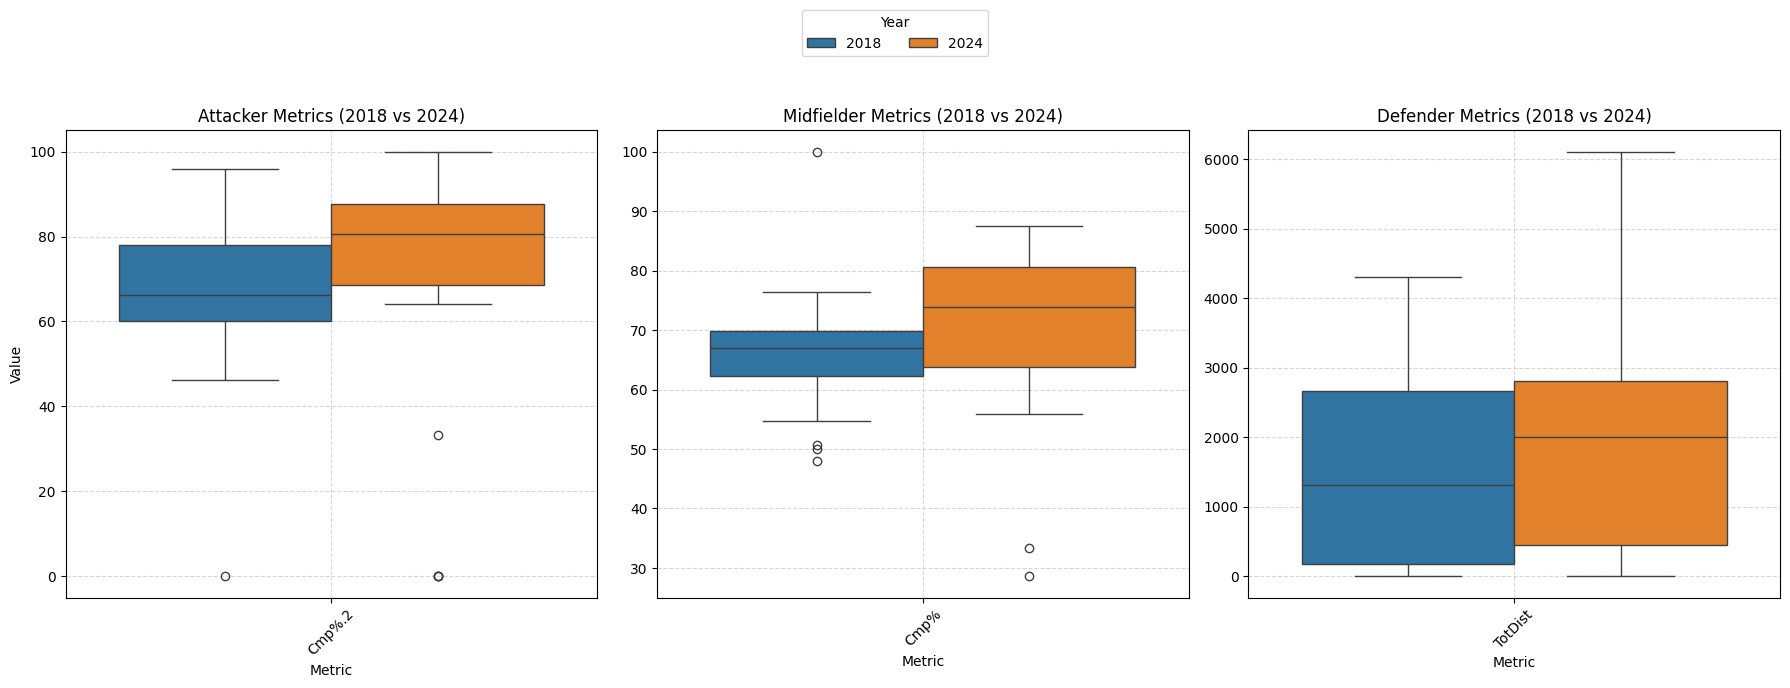

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Role-based metrics selection
role_metrics = {
    "Defender": ["TotDist"],
    "Midfielder": ["Cmp%"],
    "Attacker": ["Cmp%.2"],
    "Goalkeeper": []
}

# Relevant sheets per role
role_sheets = {
    "Attacker": ["standard_stats", "shooting", "possession", "passing"],
    "Defender": ["standard_stats", "defensive_action", "possession"],
    "Midfielder": ["standard_stats", "passing", "possession", "defensive_action"],
    "Goalkeeper": ["standard_stats", "goalkeeping", "advanced_goalkeeping"]
}

# Prepare data for box plots
boxplot_data = []
outlier_instances = []

# Loop through filtered data
for df_name, df in filtered_data.items():
    # Extract year from the df_name
    year = 2018 if "2018" in df_name else 2024

    # Identify the base sheet name (removing year suffix)
    sheet_base_name = "_".join(df_name.split("_")[:-1])

    # Loop through roles to check if this DataFrame is relevant
    for role, valid_sheets in role_sheets.items():
        if sheet_base_name not in valid_sheets:  # Skip irrelevant sheets
            continue
        if role not in role_metrics or not role_metrics[role]:  # Skip Goalkeeper (no metrics)
            continue

        # Check if the DataFrame contains the columns of interest
        for metric in role_metrics[role]:
            if metric in df.columns:
                metric_values = df[metric].dropna()

                # Calculate Q1, Q3, and IQR
                Q1 = metric_values.quantile(0.25)
                Q3 = metric_values.quantile(0.75)
                IQR = Q3 - Q1

                # Define outlier bounds
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                # Loop through values to detect outliers
                for index, value in metric_values.items():
                    player = df.loc[index, "Player"] if "Player" in df.columns else "Unknown"

                    # Store all data for boxplot (ensuring Player is saved)
                    boxplot_data.append({
                        "Role": role, "Metric": metric, "Player": player, "Year": year, "Value": value
                    })

                    # Identify outliers
                    if value < lower_bound or value > upper_bound:
                        outlier_instances.append({
                            "Sheet": df_name,
                            "Player": player,
                            "Metric": metric,
                            "Outlier Value": value
                        })

# Print detected outliers
if outlier_instances:
    print("\n🚨 Outliers Detected:")
    for outlier in outlier_instances:
        print(f"📌 Sheet: {outlier['Sheet']} | Player: {outlier['Player']} | "
              f"Metric: {outlier['Metric']} | Outlier Value: {outlier['Outlier Value']}")
else:
    print("\n✅ No outliers detected.")

# Convert list to DataFrame for plotting
boxplot_df = pd.DataFrame(boxplot_data)

# Create subplots for each role
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Define role order for consistency
roles_to_plot = ["Attacker", "Midfielder", "Defender"]

# Custom color palette for better visibility
custom_palette = {2018: "#1f77b4", 2024: "#ff7f0e"}  # Blue for 2018, Orange for 2024

# Loop through each role and plot separately
for i, role in enumerate(roles_to_plot):
    role_df = boxplot_df[boxplot_df["Role"] == role]

    if not role_df.empty:
        sns.boxplot(
            x="Metric", y="Value", hue="Year", data=role_df, ax=axes[i], palette=custom_palette
        )
        axes[i].set_title(f"{role} Metrics (2018 vs 2024)")
        axes[i].set_xlabel("Metric")
        axes[i].set_ylabel("Value" if i == 0 else "")  # Only first plot shows Y-label
        axes[i].tick_params(axis='x', rotation=45)  # Rotate labels for readability
        axes[i].grid(True, linestyle="--", alpha=0.5)

# Remove individual legends
handles, labels = axes[0].get_legend_handles_labels()
for ax in axes:
    ax.get_legend().remove()

# Create a single legend outside the plot
fig.legend(handles, labels, title="Year", loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.15))

# Adjust layout
plt.tight_layout()
plt.show()


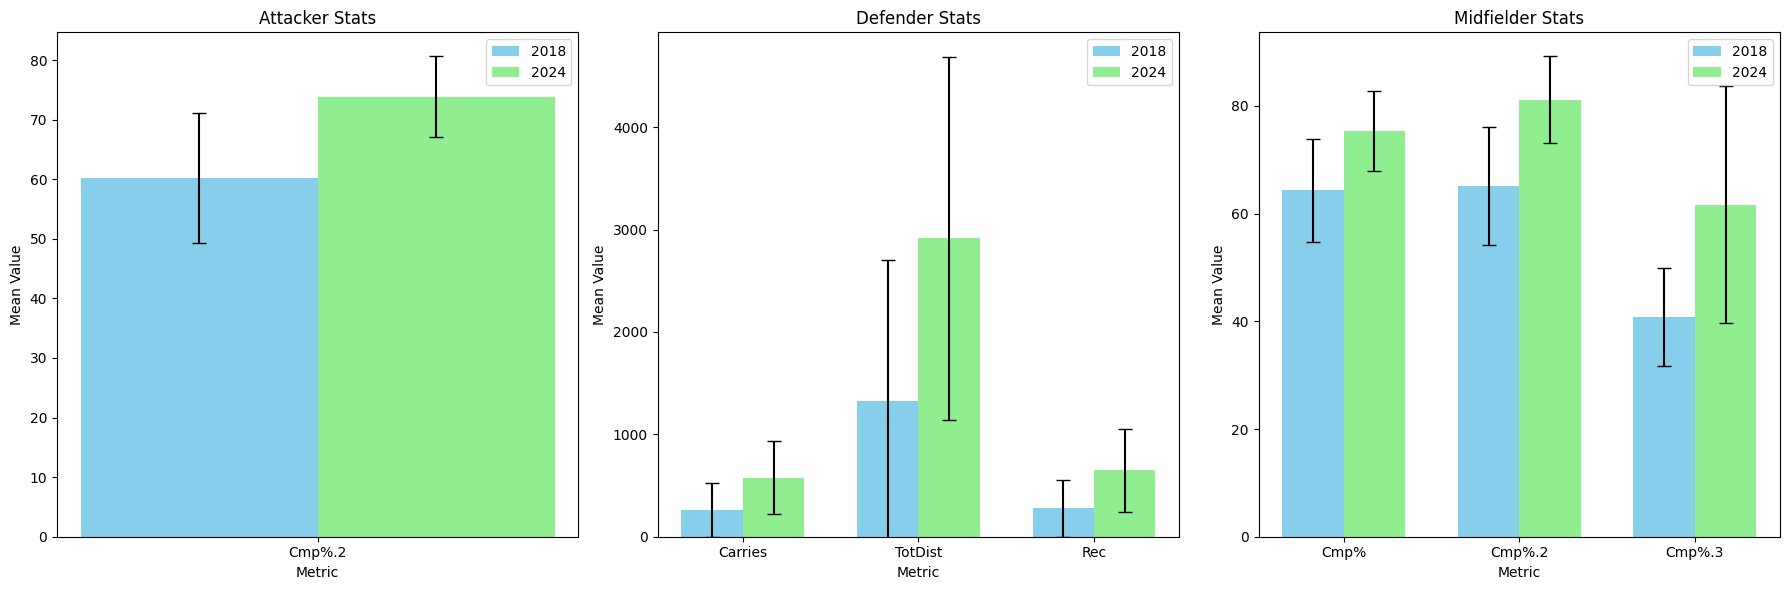

In [77]:
# Load data
attacker_summary = pd.read_csv('RBNY_yearly_stats/summary_stats/attacker_stats_summary.csv')
defender_summary = pd.read_csv('RBNY_yearly_stats/summary_stats/defender_stats_summary.csv')
midfielder_summary = pd.read_csv('RBNY_yearly_stats/summary_stats/midfielder_stats_summary.csv')

# Correct filtering using `.isin()`
filtered_attacker = attacker_summary[attacker_summary['Metric'] == 'Cmp%.2']
filtered_defender = defender_summary[defender_summary['Metric'].isin(['Carries', 'TotDist', 'Rec'])]
filtered_midfielder = midfielder_summary[midfielder_summary['Metric'].isin(['Cmp%', 'Cmp%.2', 'Cmp%.3'])]

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Independent y-axes

# Function to plot bar chart with centered error bars and separate bars for 2018 and 2024
def plot_with_errorbars(ax, data, title):
    metrics = data['Metric'].unique()
    bar_width = 0.35  # Width of the bars
    x_positions = np.arange(len(metrics))  # X positions for bars
    
    # Check if the plot is for Attacker, adjust x_position for one metric
    if title == "Attacker Stats":
        x_positions = [0]  # Only one metric, place it at x = 0

    # Plot bars for 2018 and 2024 (side by side)
    for i, metric in enumerate(metrics):
        metric_data_2018 = data[(data['Metric'] == metric) & (data['Year'] == 2018)]
        metric_data_2024 = data[(data['Metric'] == metric) & (data['Year'] == 2024)]
        
        ax.bar(x_positions[i] - bar_width / 2, metric_data_2018['Mean'], width=bar_width, color='skyblue', label='2018' if i == 0 else "", yerr=metric_data_2018['Std'], capsize=5)
        ax.bar(x_positions[i] + bar_width / 2, metric_data_2024['Mean'], width=bar_width, color='lightgreen', label='2024' if i == 0 else "", yerr=metric_data_2024['Std'], capsize=5)
    
    # Add labels and title
    ax.set_title(title)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(metrics)
    ax.set_xlabel("Metric")
    ax.set_ylabel("Mean Value")
    ax.set_ylim(bottom=0)  # Ensure y-axis starts at 0
    ax.legend()

# Plot for Attackers
plot_with_errorbars(axes[0], filtered_attacker, "Attacker Stats")

# Plot for Defenders
plot_with_errorbars(axes[1], filtered_defender, "Defender Stats")

# Plot for Midfielders
plot_with_errorbars(axes[2], filtered_midfielder, "Midfielder Stats")

# Adjust layout for clarity
plt.tight_layout()
plt.show()


Do correlation between all metrics and ppg to determine which metric predicts the team performance

Focus on the significant metrics that are considered important for the specific player role.
- expplain the difference betwene 2018 and 2024. does it make sence based on the high performance in 2018?

Maybe look at specific players and their performance based on avgs.


In [14]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

# Define role-specific columns
role_columns = {
    'Attacker': ['Total Scoring Attempts'],
    'Midfielder': ['Assists', 'Total Scoring Attempts']
}

# Initialize a list to store results
results = []

# Function to check normality and plot distributions
def check_normality(data, column):
    stat, p_value = shapiro(data[column].dropna())
    return p_value > 0.05, stat, p_value

# Perform statistics for each role and column
for role, columns in role_columns.items():
    role_data = combined_season[(combined_season['Role'] == role) & (combined_season['Team'] == 'RBNY')]
    game_role_data = combined_game[(combined_game['Role'] == role) & (combined_game['Team'] == 'RBNY')]
    print(role_data)
    for column in columns:
        # Check normality for season and game data
        season_normal, season_stat, season_p = check_normality(role_data, column)
        game_normal, game_stat, game_p = check_normality(game_role_data, column)
        
        # Perform statistical test between season and game data
        if season_normal and game_normal:
            # Use t-test
            test_name = "T-Test"
            stat, p_value = ttest_ind(role_data[column].dropna(), game_role_data[column].dropna())
        else:
            # Use Mann-Whitney U test
            test_name = "Mann-Whitney U Test"
            stat, p_value = mannwhitneyu(role_data[column].dropna(), game_role_data[column].dropna())
        
        # Determine conclusion
        conclusion = "Significant Difference" if p_value < 0.05 else "No Significant Difference"
        
        # Append results to the list
        results.append({
            'Role': role,
            'Metric': column,
            'Season Normal (P-Value)': season_p,
            'Game Normal (P-Value)': game_p,
            'Test Used': test_name,
            'Test Stat': stat,
            'P-Value': p_value,
            'Conclusion': conclusion
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Export results to an Excel file
output_file = "Player_Role_Analysis.xlsx"
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    results_df.to_excel(writer, index=False, sheet_name='Analysis Results')
    print(f"Results saved to {output_file}")


    Last Name First Name       Date    OPP Result  Goals  Assists  \
48     Manoel      Elias  Sat 10/19  vsCLB   L3-2    0.0      0.0   
49     Manoel      Elias   Sat 10/5   @ATL   L2-1    0.0      0.0   
50     Manoel      Elias   Wed 10/2   @TOR   W4-1    1.0      0.0   
51     Manoel      Elias   Sat 9/28  vsNYC   L5-1    0.0      0.0   
52     Manoel      Elias   Sat 9/21  vsATL   D2-2    1.0      0.0   
..        ...        ...        ...    ...    ...    ...      ...   
622  Mitchell      Roald   Sat 3/23  vsMIA   W4-0    0.0      0.0   
623  Mitchell      Roald   Sat 3/16   @CLB   L3-0    0.0      0.0   
624  Mitchell      Roald    Sat 3/9  vsDAL   W2-1    0.0      0.0   
625  Mitchell      Roald    Sat 3/2   @HOU   W2-1    0.0      0.0   
626  Mitchell      Roald   Sun 2/25   @NSH   D0-0    0.0      0.0   

     On Target Scoring Attempts  Total Scoring Attempts  Fouls Committed  \
48                          1.0                     0.0              0.0   
49                 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [15]:
role_data = combined_season[(combined_season['Role'] == role) & (combined_season['Team'] == 'RBNY')]
game_role_data = combined_game[(combined_game['Role'] == role) & (combined_game['Team'] == 'RBNY')]